In [571]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PWD = Path.cwd()

In [572]:
df = pd.read_csv(
    f'{PWD}/LLM+Answer+Evaluation_18+September+2024_10.03.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../survey.jsonl', lines=True)


datasets = questions['dataset'].unique()[:-1]
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


def t2i(
    text: str,
    point_scale: int = 5,
) -> int:
    if point_scale == 5:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 2,
            'Neither agree nor disagree': 3,
            'Somewhat agree': 4,
            'Strongly agree': 5,
        }
    elif point_scale == 3:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 1,
            'Neither agree nor disagree': 2,
            'Somewhat agree': 3,
            'Strongly agree': 3,
        }

    return mapping.get(text, None)


def i2t(
    integer: int,
    point_scale: int = 5,
) -> str:
    if point_scale == 5:
        mapping = {
            1: 'SD',
            2: 'sD',
            3: 'N',
            4: 'sA',
            5: 'SA',
        }
    elif point_scale == 3:
        mapping = {
            1: 'SD',
            2: 'N',
            3: 'SA',
        }

    return mapping.get(integer, None)

In [573]:
datasets, models

(array(['Franklin', 'GSM8k', 'HotpotQA', 'StrategyQA'], dtype=object),
 array(['google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'microsoft/Phi-3.5-mini-instruct', 'openai/gpt-4o-mini'],
       dtype=object))

In [574]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_response,html
0,1c9b5176-426a-4204-846b-a3f8b500f14f,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,"I do not have access to real-time information,...",<p><em>Which country will have the lower energ...
1,a58302d2-d144-4f4f-8f3b-b56220312d6b,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Northern Europe had th...
2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Eastern Asia had the h...
3,f7f44e54-e848-4e48-a6d7-e1fa552754d4,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,I cannot answer this question. \n\nHere's why:...,<p><em>For the country in Micronesia that had ...
4,da574fdf-3fc9-4191-a373-b015b3584e8b,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here's how to approach this question:\n\n* **L...,<p><em>Which country will have the higher life...


In [575]:
# set column name to item in row 0
df.columns = df.iloc[0]
# drop the first row
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')
# remove rows where Finished is not True
df = df[df['Finished'] == 'True']
df.head()

,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,"3efe2b88-9e40-4a1c-8587-ac7b524f9233_1 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - The response answers the question.","3efe2b88-9e40-4a1c-8587-ac7b524f9233_2 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - The response includes a clear step-by-step plan of how an answer was found.","3efe2b88-9e40-4a1c-8587-ac7b524f9233_3 - Would it be unusual to find a yellow perch in the Red Sea?Yes, it would be unusual to find a yellow perch in the Red Sea. Yellow perch (Perca flavescens) are freshwater fish native to North America, primarily found in lakes and rivers. The Red Sea is a saltwater environment, and yellow perch are not adapted to live in such conditions. Therefore, it is highly unlikely to encounter yellow perch in the Red Sea. - I would be satisfied with this response if I had asked the question.","9b038805-caa5-4e34-ba1c-83856376c705_1 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - The response answers the question.","9b038805-caa5-4e34-ba1c-83856376c705_2 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - The response includes a clear step-by-step plan of how an answer was found.","9b038805-caa5-4e34-ba1c-83856376c705_3 - Did Electronic Arts profit from Metroid sales?No, Electronic Arts (EA) did not profit from Metroid sales. The Metroid series is developed and published by Nintendo, not EA. Therefore, any profits from Metroid sales would go to Nintendo, not Electronic Arts. - I would be satisfied with this response if I had asked the question.","6f401f5d-264c-4bd3-98a2-e3e0826eef74_1 - Can someone from New England profit by growing coffee?Growing coffee in New England presents significant challenges due to the region's climate, which is generally not suitable for coffee cultivation. Coffee plants typically thrive in tropical and subtropical climates with consistent temperatures between 60°F and 70°F (15°C to 24°C) and specific humidity levels. New England's colder winters and shorter growing seasons make it difficult to grow coffee plants outdoors.\nHowever, there are some possibilities for growing coffee in New England:\n\n\nGreenhouses: Some growers may experiment with coffee cultivation in greenhouses, where they can control temperature and humidity. This method could potentially allow for small-scale production.\n\n\nIndoor Growing: With the right equipment, coffee plants can be grown indoors. This method requires careful attention to light, temperature, and humidity but could yield small amounts of coffee.\n\n\nSpecialty Markets: If successful, growers could tap into niche markets for locally grown coffee, which may attract consumers interested in unique or sustainable products.\n\n\nResearch and Development: Some agricultural research inst

In [576]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [577]:
df.head()

,1c9b5176-426a-4204-846b-a3f8b500f14f_1,1c9b5176-426a-4204-846b-a3f8b500f14f_2,1c9b5176-426a-4204-846b-a3f8b500f14f_3,a58302d2-d144-4f4f-8f3b-b56220312d6b_1,a58302d2-d144-4f4f-8f3b-b56220312d6b_2,a58302d2-d144-4f4f-8f3b-b56220312d6b_3,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_1,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_3,f7f44e54-e848-4e48-a6d7-e1fa552754d4_1,...,2a4d3a82-d078-433f-a8e5-0afba428ddc3_3,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_1,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_2,f94c9a05-fc8a-493e-a6a6-4f59cc09a3d1_3,8c862220-256d-485d-aa66-2ad1fbc84610_1,8c862220-256d-485d-aa66-2ad1fbc84610_2,8c862220-256d-485d-aa66-2ad1fbc84610_3,1327c3e0-7700-4915-8b43-fce639d9cd44_1,1327c3e0-7700-4915-8b43-fce639d9cd44_2,1327c3e0-7700-4915-8b43-fce639d9cd44_3
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
60cd16e63d3924958e8d3d43,NaN,NaN,NaN,Strongly disagree,Strongly disagree,Strongly disagree,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Strongly disagree,Strongly disagree,Strongly disagree,NaN,NaN,NaN
5e90a3adb3e1243bdcfaf973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neither agree nor disagree,...,NaN,NaN,NaN,NaN,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,NaN,NaN,NaN
60f20aac9a3cd813c94175b4,NaN,NaN,NaN,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,NaN,NaN,NaN,NaN,...,Strongly agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ced2f25eb7beb158c802d5,NaN,NaN,NaN,NaN,NaN,NaN,Strongly disagree,Strongly disagree,Strongly disagree,NaN,...,NaN,Strongly agree,Strongly disagree,Strongly agree,NaN,NaN,NaN,NaN,NaN,NaN
615e172f0c76d81d3ac38937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strongly disagree,...,Somewhat agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Attention checks

In [578]:
attention_check_somewhat_agree = [f'd67998d7-8f14-4f50-823b-cb63027f21d9_{i}' for i in range(1, 5)]
attention_check_strongly_disagree = [f'e45763f5-53c4-4006-b2f8-edfbfd7e289e_{i}' for i in range(1, 5)]
# make a dataframe with the attention check columns
attention_check_df = df[attention_check_somewhat_agree + attention_check_strongly_disagree]
# drop these columns from the dataframe
df = df.drop(attention_check_df.columns, axis=1)
# confirm specific columns contains the correct values
failed_checks = attention_check_df[~attention_check_df['d67998d7-8f14-4f50-823b-cb63027f21d9_4'].isin(['Somewhat agree'])]
failed_checks = pd.concat(
    [
        failed_checks,
        attention_check_df[~attention_check_df['e45763f5-53c4-4006-b2f8-edfbfd7e289e_4'].isin(['Strongly disagree'])],
    ]
)
# rename a column
failed_checks = failed_checks.rename(
    columns={
        'd67998d7-8f14-4f50-823b-cb63027f21d9_4': 'Somewhat agree',
        'e45763f5-53c4-4006-b2f8-edfbfd7e289e_4': 'Somewhat disagree',
    }
)
failed_checks[['Somewhat agree', 'Somewhat disagree']]

,Somewhat agree,Somewhat disagree
PROLIFIC_PID,,
55884887fdf99b4020ba09bb,Somewhat disagree,Strongly disagree


In [579]:
"""
Split main dataframe into 3 dataframes for each variation of the question.
Split also by dataset and model.
"""
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
ask, plan, sat = {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    ask[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]]
    plan[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]]
    sat[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]]

all_ask = pd.concat(ask.values(), axis=1)
all_plan = pd.concat(plan.values(), axis=1)
all_sat = pd.concat(sat.values(), axis=1)

ask_mean_std = []
plan_mean_std = []
sat_mean_std = []

for dataset, model in grouped_uuids.keys():
    ask_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [ask[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
        }
    )
    plan_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [plan[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
        }
    )
    sat_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [sat[(dataset, model)].map(lambda x: t2i(x, 3)).std().mean()],
        }
    )

ask_mean_std = pd.DataFrame(ask_mean_std)
plan_mean_std = pd.DataFrame(plan_mean_std)
sat_mean_std = pd.DataFrame(sat_mean_std)

In [580]:
def remove_outliers(
    df_dict: dict[tuple, pd.DataFrame],
) -> dict[tuple, pd.DataFrame]:
    """Remove outliers from a dataframe using the IQR method.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model with outliers removed.

    """

    def get_outliers(df):
        df = df.map(t2i)
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1

        outlier_columns = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]
        return outlier_columns

    outlier_info = []
    for (dataset, model), df in df_dict.items():
        outliers = get_outliers(df)
        df_dict[(dataset, model)] = df[~outliers.notna().any(axis=1)]
        # percentage of outliers for a given dataset and model
        outlier_info.append(
            {
                'dataset': dataset,
                'model': model,
                # divide by number of non-nan values in a column
                'percentage': np.mean(outliers.count() / df.count()),
            }
        )

    return df_dict, pd.DataFrame(outlier_info)


# ask, ask_outliers = remove_outliers(ask)
# plan, plan_outliers = remove_outliers(plan)
# sat, sat_outliers = remove_outliers(sat)

In [581]:
def majority_vote(df_dict: dict[tuple, pd.DataFrame]) -> pd.DataFrame:
    """Majority vote for a dataframe.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the majority vote for each dataset and model.

    """
    # for each col in a df, set each value to the most common value
    for (dataset, model), df in df_dict.items():
        df_dict[(dataset, model)] = df.apply(lambda x: x.mode().to_numpy()[0], axis=0)

    return df_dict


ask = majority_vote(ask)
plan = majority_vote(plan)
sat = majority_vote(sat)

In [582]:
# dataset = 'Franklin'
# dataset = 'GSM8k'
# dataset = 'HotpotQA'
dataset = 'StrategyQA'
# model = 'google/gemma-2-9b-it'
# model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
# model = 'openai/gpt-4o-mini'
ask[(dataset, model)].map(t2i).sem()

0.8660254037844386

In [583]:
ask[(dataset, model)].map(t2i)

0
7275d1fd-016d-4df5-a4c3-0b9818e812c4_1    4
1b26fe40-49fe-4668-9ca4-2a4d8833b241_1    1
4a78101f-43a4-40d6-bd8f-1b5f496967f7_1    4
94547c28-43cd-4b43-b70e-a4cb697a4e18_1    5
dtype: int64

In [584]:
# do sem for each dataset and model, taking random samples of 4 responses from each column
# check if sem increases with fewer responses

rows = []
for (dataset, model), df in grouped_uuids.items():
    cols = ask[(dataset, model)].map(lambda x: t2i(x, 5))
    # get non-nan values of columns
    cols = np.transpose(cols[~pd.isna(cols)].to_numpy())
    # remove nan values
    cols = [col[~np.isnan(col)] for col in cols]
    # compute sem for all 8 responses across all columns
    sem = pd.Series([pd.Series(col).sem() for col in cols])
    sem_mean = sem.mean()
    sem_std = sem.std()
    # get mean value for all cols
    mean = pd.Series([pd.Series(col).mean() for col in cols]).mean()
    # get std value for all cols
    std = pd.Series([pd.Series(col).std() for col in cols]).mean()
    # compute sem for all possible n=4 samples of responses
    # sem_4 = []
    # for col in cols:
    #     combs = itertools.combinations(col, 4)
    #     sem_4.append(pd.Series([pd.Series(comb).sem() for comb in combs]).mean())

    # ci_8 = 1.96 * sem_8_mean
    # ci_4 = 1.96 * np.mean(sem_4)
    # ci_8_width = ci_8 * 2
    # ci_4_width = ci_4 * 2

    sem = rows.append(
        {
            'dataset': dataset,
            'model': model,
            'mean': mean,
            'std': std,
            'sem-mean': sem_mean,
            # 'sem-8-std': sem_8_std,
            # 'sem-4-mean': np.mean(sem_4)
            # 'sem-4-std': np.std(sem_4),
            # 'sem_increase (%)': (np.mean(sem_4) - sem_8_mean) / sem_8_mean * 100,
            # t-test
            # 't-test': ttest_rel(sem_8, sem_4).pvalue < 0.05,
        }
    )

# floats to 3 decimal places
sem_df = pd.DataFrame(rows).round(2)
sem_df

,dataset,model,mean,std,sem-mean
0,Franklin,google/gemma-2-9b-it,1.00,NaN,NaN
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,2.00,NaN,NaN
2,Franklin,microsoft/Phi-3.5-mini-instruct,1.50,NaN,NaN
3,Franklin,openai/gpt-4o-mini,2.25,NaN,NaN
4,GSM8k,google/gemma-2-9b-it,4.25,NaN,NaN
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,4.00,NaN,NaN
6,GSM8k,microsoft/Phi-3.5-mini-instruct,3.75,NaN,NaN
7,GSM8k,openai/gpt-4o-mini,5.00,NaN,NaN
8,HotpotQA,google/gemma-2-9b-it,3.75,NaN,NaN
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,1.00,NaN,NaN


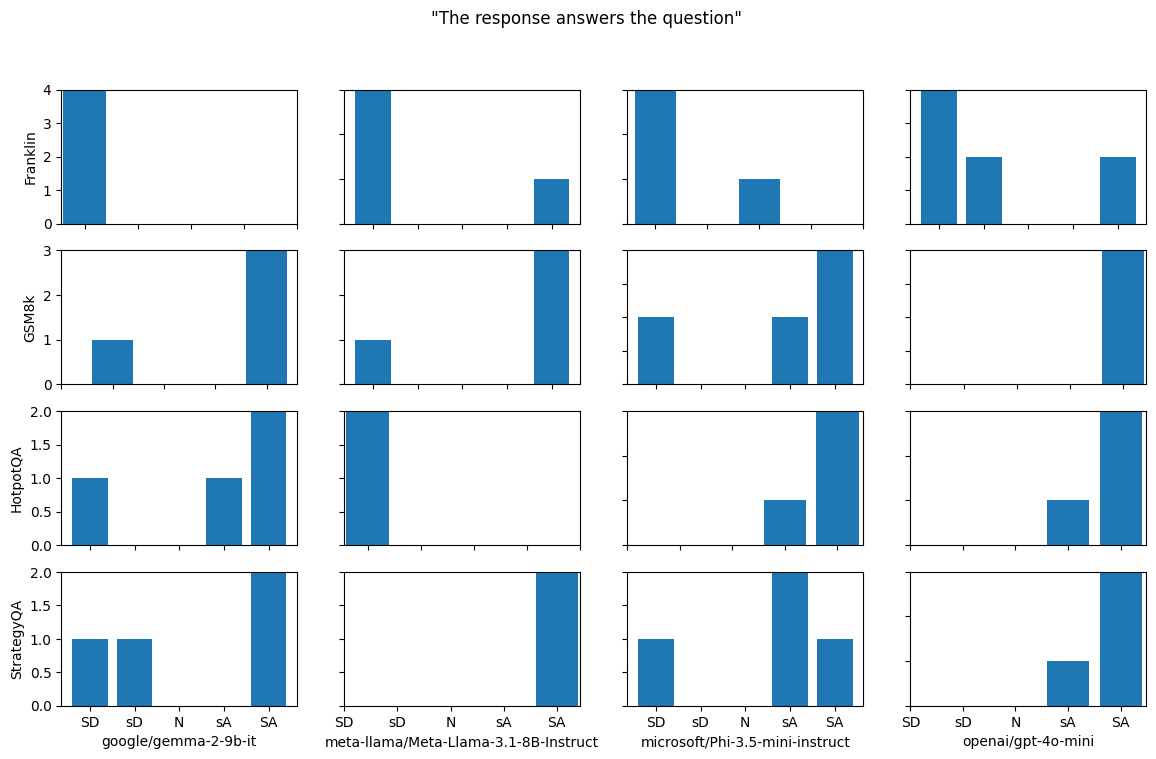

In [585]:
point_scale = 5

# subplots in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(14, 8))

for d, dataset in enumerate(datasets):
    for m, model in enumerate(models):
        values = ask[(dataset, model)].map(lambda x: t2i(x, point_scale)).to_numpy()
        # remove nan values from numpy array
        values = values[~pd.isna(values)]
        # frequency of each value
        counts = pd.Series(values).value_counts()
        # plot the frequency of each value
        axs[d, m].bar(counts.index, counts.values)
        # set x axis to i2t for each value
        axs[d, m].set_xticks(range(1, point_scale + 1))
        axs[d, m].set_xticklabels([i2t(i, point_scale) for i in range(1, point_scale + 1)], ha='center')
        # set y axis to 0-max frequency
        axs[d, m].set_ylim(0, counts.max())
        # set x axis label to the model
        axs[d, m].set_xlabel(model)
        # set y axis label to the dataset
        axs[d, m].set_ylabel(dataset)

# only show bottom x axis labels
for ax in axs.flat:
    ax.label_outer()

# set the title of the entire plot
fig.suptitle('"The response answers the question"')
plt.show()

In [586]:
dataset = 'Franklin'
dataset = 'GSM8k'
dataset = 'HotpotQA'
dataset = 'StrategyQA'
model = 'google/gemma-2-9b-it'
model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
model = 'openai/gpt-4o-mini'
# get questions['question'] with uuids from grouped_uuids[(dataset, model)]
questions = questions[(questions['dataset'] == dataset) & (questions['model'] == model)]